In [4]:
!pip install squarify
!pip install networkx

IMPORTS & SETUP

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import codecs
import networkx as nx
import squarify
from itertools import combinations
from collections import Counter
from scipy.stats import skew, kurtosis

sns.set(style="whitegrid", palette="muted", font_scale=1.1)

LOAD & CLEAN DATA

In [7]:
df = pd.read_csv('startup_funding.csv')

Rename columns

In [8]:
column_mapping = {
    'SNo': 'Sr_No',
    'Date dd/mm/yyyy': 'Date',
    'Startup Name': 'Startup_Name',
    'Industry Vertical': 'Industry_Vertical',
    'SubVertical': 'SubVertical',
    'City  Location': 'City',
    'City Location': 'City',
    'Investors Name': 'Investors_Name',
    'InvestmentnType': 'Investment_Type',
    'Investment Type': 'Investment_Type',
    'Amount in USD': 'Amount_USD',
    'Remarks': 'Remarks'
}
df.rename(columns=column_mapping, inplace=True)

Clean amount

In [9]:
df['Amount_USD'] = df['Amount_USD'].str.replace(',', '')
df['Amount_USD'] = pd.to_numeric(df['Amount_USD'], errors='coerce')
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna(subset=['Amount_USD', 'Date'])

Text cleanup

In [10]:
text_cols = ['City', 'Startup_Name', 'Investors_Name', 'Industry_Vertical', 'SubVertical', 'Investment_Type']
for col in text_cols:
    df[col] = df[col].astype(str).str.strip()

def clean_text(text):
    try:
        text = codecs.decode(text.encode('latin1'), 'utf-8')
    except:
        pass
    return re.sub(r'[\xa0\u200b]', ' ', text).strip()

for col in ['Startup_Name', 'Investors_Name', 'City']:
    df[col] = df[col].apply(clean_text)

Standardize investment types

In [11]:
inv_map = {
    'seed funding': 'Seed',
    'seed/ angel funding': 'Seed',
    'angel funding': 'Angel',
    'private equity': 'Private Equity',
    'venture funding': 'Venture',
    'crowd funding': 'Crowd',
}
df['Investment_Type'] = df['Investment_Type'].replace(inv_map)
df['Investment_Type'] = df['Investment_Type'].str.lower()

Normalize cities

In [12]:
df['City'] = df['City'].str.lower().replace({
    'bangalore': 'bengaluru',
    'mumbai / global': 'mumbai',
    'mumbai / ny': 'mumbai',
    'delhi': 'new delhi',
    'new delhi / us': 'new delhi',
    'gurugram': 'gurgaon',
    'noida / singapore': 'noida',
    'hyderabad/usa': 'hyderabad',
    'bangalore / san mateo': 'bengaluru'
})

Funding category

In [13]:
def funding_category(x):
    if x < 1e6: return 'Small'
    elif x < 1e7: return 'Medium'
    else: return 'Large'
df['Funding_Size'] = df['Amount_USD'].apply(funding_category)
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df = df.drop_duplicates()

DESCRIPTIVE STATISTICS

In [14]:
funding_stats = df.groupby('Investment_Type')['Amount_USD'].agg(['mean', 'median']).reset_index()
funding_stats['mode'] = df.groupby('Investment_Type')['Amount_USD'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan).values
print(funding_stats.sort_values('median', ascending=False))

                Investment_Type          mean        median          mode
15         private equity round  1.265000e+08  1.500000e+08  1.500000e+08
33               single venture  1.400000e+08  1.400000e+08  1.400000e+08
20         seed / angle funding  1.000000e+08  1.000000e+08  1.000000e+08
30                     series d  1.360799e+08  6.500000e+07  2.200000e+07
29                     series c  9.763500e+07  5.000000e+07  5.000000e+07
3               corporate round  3.808000e+07  3.808000e+07  3.808000e+07
28                     series b  2.539093e+07  1.835886e+07  1.300000e+06
13                      private  1.570000e+07  1.570000e+07  1.570000e+07
16              private funding  1.468000e+07  1.468000e+07  1.468000e+07
5   debt and preference capital  6.320820e+06  6.320820e+06  6.320820e+06
14               private equity  2.621076e+07  6.000000e+06  1.000000e+06
7                  debt-funding  5.000000e+06  5.000000e+06  5.000000e+06
27                     series a  7.313

Skewness & Kurtosis

In [15]:
amount_clean = df['Amount_USD'].dropna()
print(f"Skewness: {skew(amount_clean)}")
print(f"Kurtosis: {kurtosis(amount_clean)}")

Skewness: 21.021645394834646
Kurtosis: 531.5665244660825


VISUALIZATION - FUNDING DISTRIBUTIONS

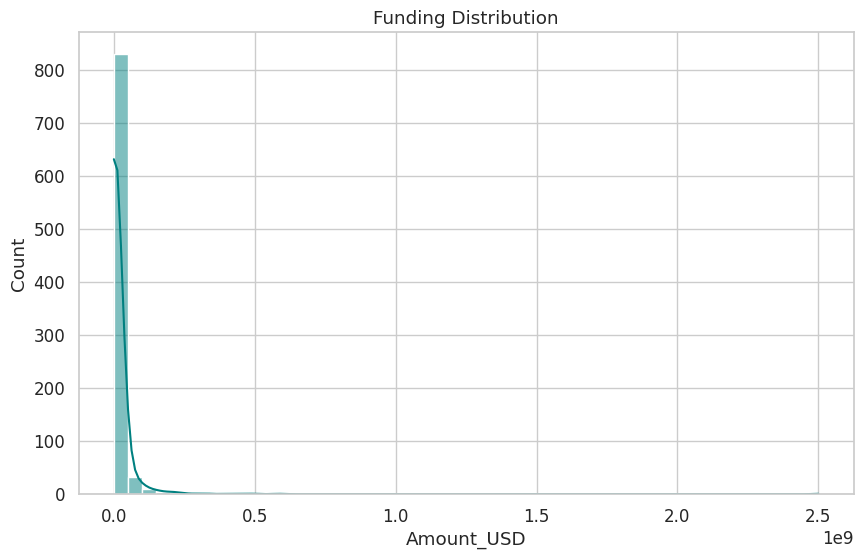

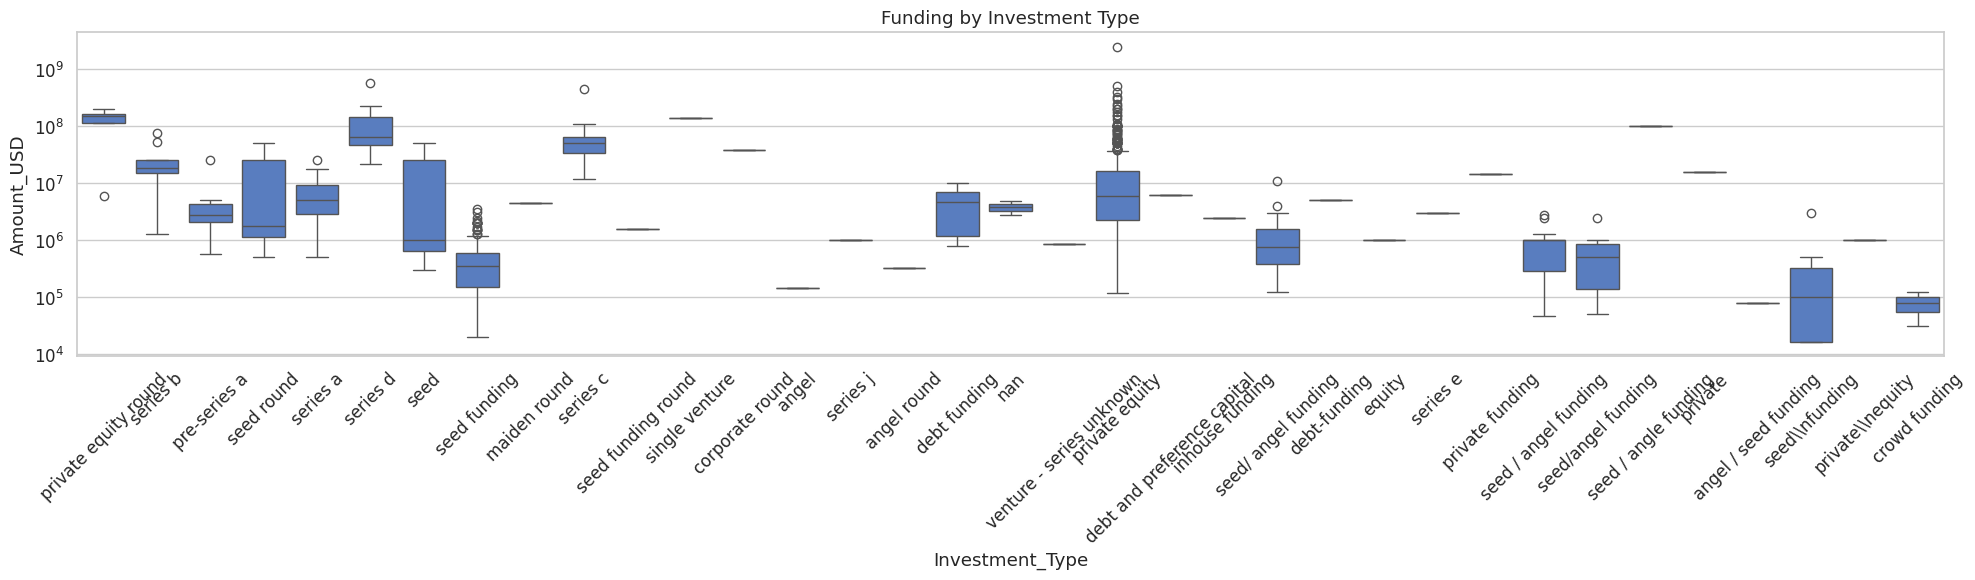

In [16]:
plt.figure(figsize=(10,6))
sns.histplot(df['Amount_USD'], bins=50, kde=True, color='teal')
plt.title('Funding Distribution')
plt.show()

plt.figure(figsize=(20, 6))
sns.boxplot(data=df, x='Investment_Type', y='Amount_USD')
plt.yscale('log')
plt.title('Funding by Investment Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

INSIGHTS - BY CITY, INDUSTRY, STARTUP

In [20]:
top_cities = df.groupby('City')['Amount_USD'].sum().sort_values(ascending=False).head(10)
top_industries = df.groupby('Industry_Vertical')['Amount_USD'].sum().sort_values(ascending=False).head(10)
top_startups = df.groupby('Startup_Name')['Amount_USD'].sum().sort_values(ascending=False).head(10)

Treemap

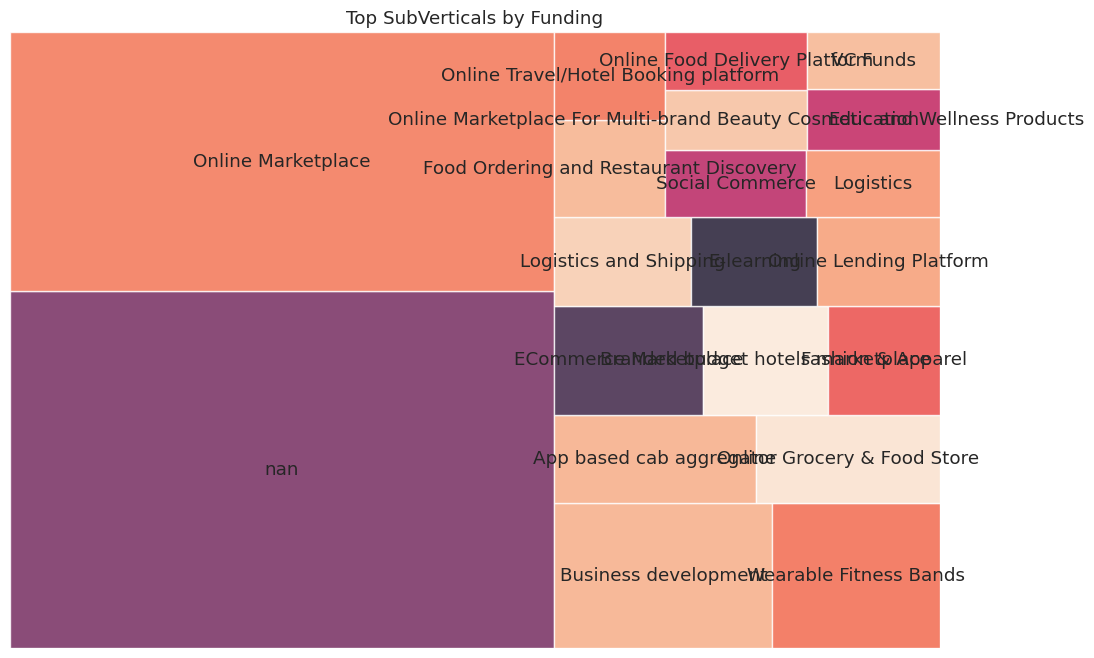

In [21]:
sub = df.groupby('SubVertical')['Amount_USD'].sum().sort_values(ascending=False).head(20)
plt.figure(figsize=(12,8))
squarify.plot(sizes=sub.values, label=sub.index, alpha=.8)
plt.axis('off')
plt.title("Top SubVerticals by Funding")
plt.show()

Pie chart - Top 5 Industries

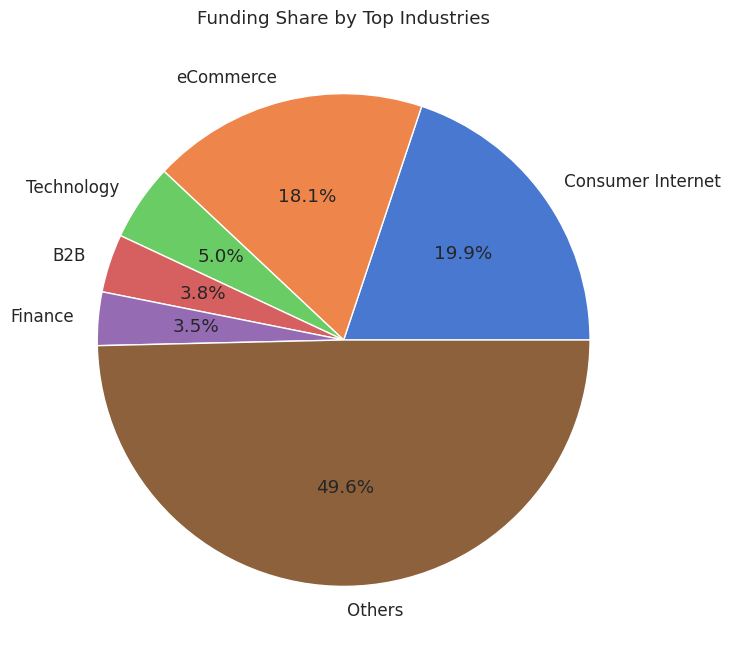

In [22]:
top_ind = df.groupby('Industry_Vertical')['Amount_USD'].sum().sort_values(ascending=False).head(5)
others_sum = df['Amount_USD'].sum() - top_ind.sum()
top_ind['Others'] = others_sum
top_ind.plot.pie(autopct='%1.1f%%', figsize=(8, 8), title='Funding Share by Top Industries')
plt.ylabel('')
plt.show()

INVESTOR INSIGHTS

(Accel Partners, Tiger Global Management)              3
(Kunal Bahl, Rohit Bansal)                             3
(Nexus Venture Partners, Tiger Global Management)      3
(Kunal Shah, Sandeep Tandon)                           3
(SAIF Partners, Sequoia Capital)                       3
(Accel Partners, SAIF Partners)                        3
(Kalaari Capital, SAIF Partners)                       2
(Michael & Susan Dell Foundation, Unitus Seed Fund)    2
(Beenext, Sequoia India)                               2
(Greenoaks Capital, SoftBank Group)                    2
Name: count, dtype: int64


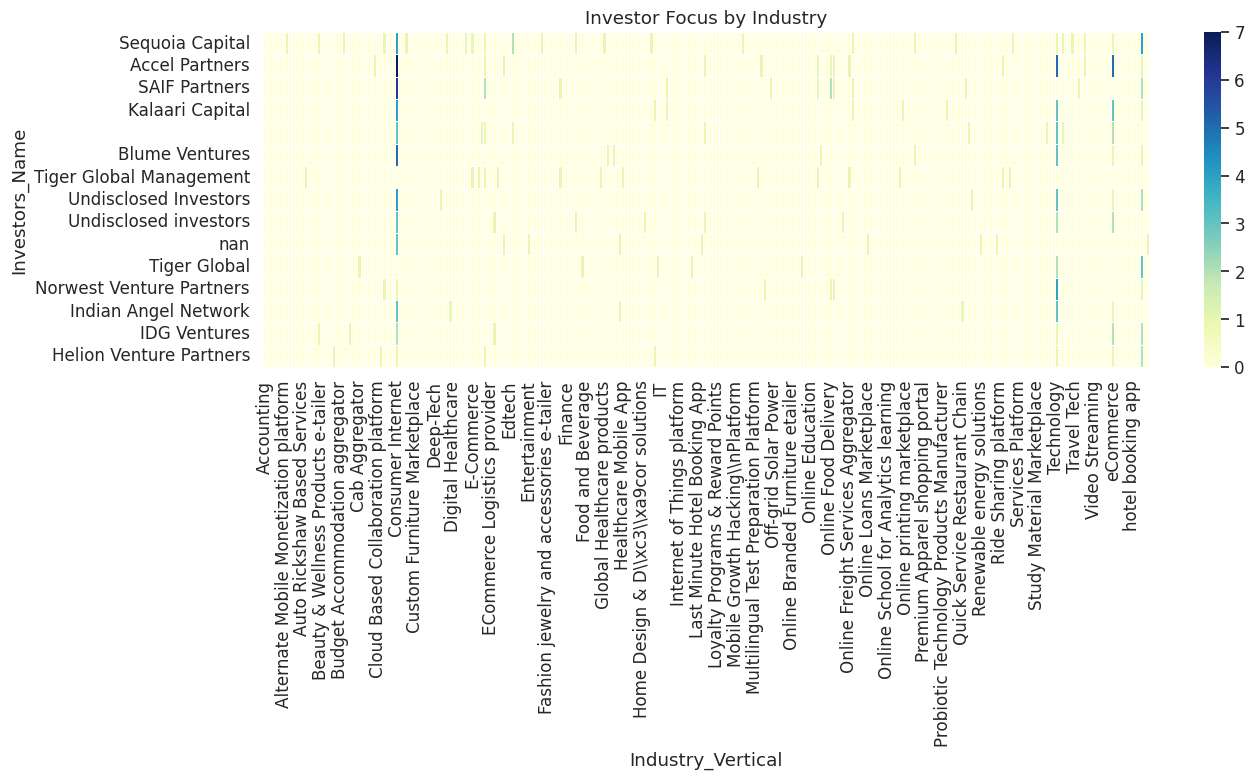

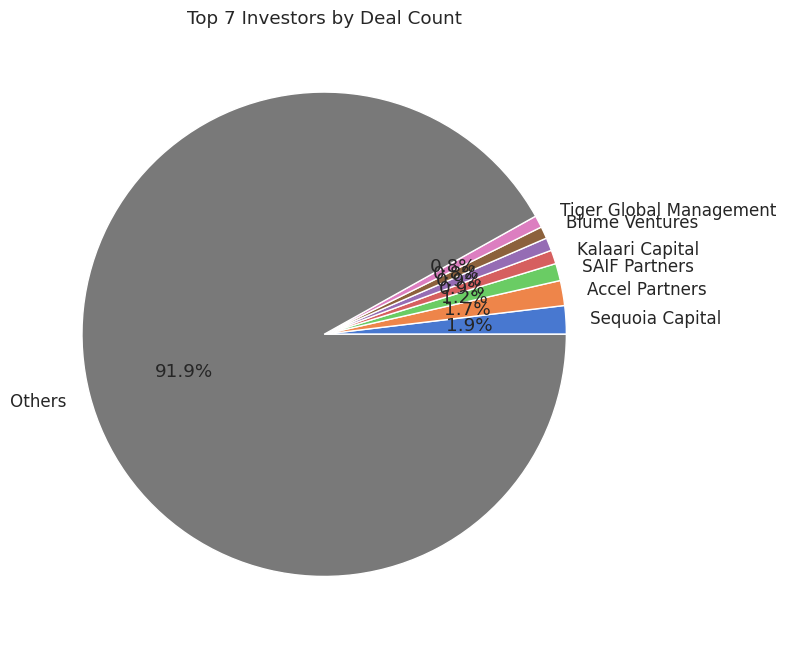

In [23]:
investors = df['Investors_Name'].dropna().str.split(',').explode().str.strip()
top_investors = investors.value_counts().head(10)

# Co-investor network
investor_pairs = df['Investors_Name'].dropna().str.split(',').apply(lambda x: [i.strip() for i in x if i.strip()])
pairs = investor_pairs.dropna().apply(lambda x: list(combinations(sorted(set(x)), 2)))
flat_pairs = [pair for sublist in pairs for pair in sublist]
pair_counts = pd.Series(flat_pairs).value_counts().head(10)
print(pair_counts)

# Heatmap: Investor vs Sector
exploded = df[['Investors_Name', 'Industry_Vertical']].dropna()
exploded = exploded.assign(Investors_Name=exploded['Investors_Name'].str.split(',')).explode('Investors_Name')
exploded['Investors_Name'] = exploded['Investors_Name'].str.strip()
heatmap_df = exploded.groupby(['Investors_Name', 'Industry_Vertical']).size().unstack(fill_value=0)
top_heatmap_investors = heatmap_df.sum(axis=1).sort_values(ascending=False).head(15).index
filtered_heatmap = heatmap_df.loc[top_heatmap_investors]

plt.figure(figsize=(14,8))
sns.heatmap(filtered_heatmap, cmap="YlGnBu", linewidths=0.5)
plt.title("Investor Focus by Industry")
plt.tight_layout()
plt.show()

# Pie chart - Top 7 Investors
top_inv = investors.value_counts().head(7)
top_inv['Others'] = investors.value_counts().iloc[7:].sum()
top_inv.plot.pie(autopct='%1.1f%%', figsize=(8, 8), title='Top 7 Investors by Deal Count')
plt.ylabel('')
plt.tight_layout()
plt.show()

TIME TRENDS

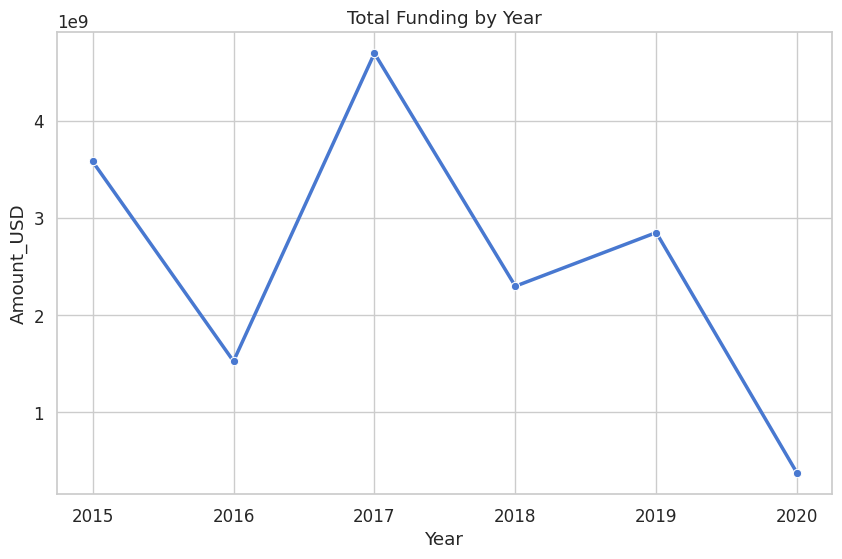

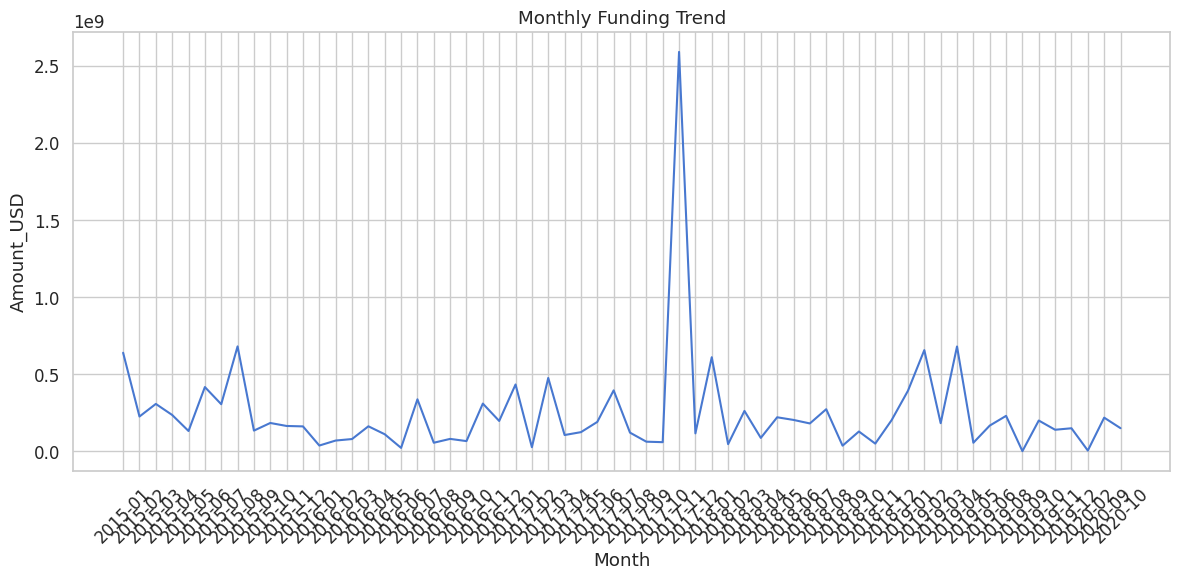

In [24]:
funding_yearly = df.groupby('Year')['Amount_USD'].sum().reset_index()
plt.figure(figsize=(10,6))
sns.lineplot(data=funding_yearly, x='Year', y='Amount_USD', marker='o', linewidth=2.5)
plt.title('Total Funding by Year')
plt.show()

# Monthly funding
df['Month'] = df['Date'].dt.to_period('M')
monthly_trend = df.groupby('Month')['Amount_USD'].sum().reset_index()
monthly_trend['Month'] = monthly_trend['Month'].astype(str)

plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_trend, x='Month', y='Amount_USD')
plt.xticks(rotation=45)
plt.title('Monthly Funding Trend')
plt.tight_layout()
plt.show()

FINAL STATS + OUTLIERS

In [26]:
outliers = df[(df['Investment_Type'] == 'seed') & (df['Amount_USD'] > 1e7)]
print("Seed Funding Outliers > $10M")
print(outliers[['Startup_Name', 'Amount_USD', 'City']])

Seed Funding Outliers > $10M
   Startup_Name  Amount_USD       City
9  Dhruva Space  50000000.0  bengaluru
